In [1]:
from timeseries_ml_utils.data import DataFetcher, DataGenerator
from timeseries_ml_utils.statistics import RelativeAccuracy, relative_dtw_times_r2
from scipy.fftpack import dct, idct
from keras.models import Sequential, load_model
from keras.layers import Input, Dense, GRU, Embedding, LSTM
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.utils import plot_model
from keras.callbacks import TensorBoard
import keras
import matplotlib.pyplot as plt
import re

Using TensorFlow backend.


In [2]:
# fetch data
data = DataFetcher(["GLD.US"], limit=450)
data.fetch_data().tail()


,GLD.US.Open,GLD.US.High,GLD.US.Low,GLD.US.Close,GLD.US.Volume
Date,,,,,
2018-11-13,113.72,113.93,113.42,113.70,9309074
2018-11-14,113.53,115.06,113.46,114.64,13950218
2018-11-15,114.83,114.99,114.56,114.77,8910585
2018-11-16,115.83,115.88,115.37,115.62,8576955
2018-11-19,115.45,115.92,115.37,115.67,8508445


In [3]:
print(len(data.get_dataframe()))
model_data = DataGenerator(data.get_dataframe(), {"^trigonometric": False, "(Open|High|Low|Close)$": True}, {"GLD.US.Close$": True},
                           aggregation_window_size=16)
print(model_data.batch_feature_shape)
print(model_data.batch_label_shape)
model_data.features, model_data.labels


450


(100, 260, 224)
(100, 16)


([('GLD.US.Open', True),
  ('GLD.US.High', True),
  ('GLD.US.Low', True),
  ('GLD.US.Close', True),
  ('trigonometric_time.cos_dow', False),
  ('trigonometric_time.sin_dow', False),
  ('trigonometric_time.cos_woy', False),
  ('trigonometric_time.sin_woy', False),
  ('trigonometric_time.cos_doy', False),
  ('trigonometric_time.sin_doy', False),
  ('trigonometric_time.sin_yer', False),
  ('trigonometric_time.cos_yer', False),
  ('trigonometric_time.sin_dec', False),
  ('trigonometric_time.cos_dec', False)],
 [('GLD.US.Close', True)])

In [5]:
model = Sequential(name="LSTM-Model-1")
model.add(LSTM(model_data.batch_label_shape[-1],
               name="LSTM-Layer-1",
               batch_input_shape=model_data.batch_feature_shape,
               activation='tanh',
               dropout=0,
               recurrent_dropout=0,
               stateful=True,
               return_sequences=model_data.return_sequences))

model.compile("Adam", loss="mse")
print(model.layers[0].get_weights()[0][0])
model.save("/tmp/keras-foo-1.h5")

[-0.02928725 -0.00716728 -0.01256733  0.00257042  0.05397308 -0.1077037
  0.09715179 -0.05417088 -0.07056453  0.1096482   0.11780611  0.08534791
  0.11625084  0.13824913 -0.01422304  0.14350414 -0.01985689 -0.09228562
 -0.09484018  0.09713967 -0.07598808 -0.05016444  0.02022827  0.000559
 -0.04275361  0.10152352  0.10485409  0.13008419 -0.13671173  0.1255565
  0.00154571  0.09884307 -0.13587244 -0.07549354  0.06256087  0.00030965
 -0.12468909  0.06300683  0.04363492 -0.10279356  0.13097894  0.05305566
  0.09298956  0.01553582 -0.03750502 -0.13196848 -0.06208688  0.07718702
  0.04036555 -0.0333949   0.01416168  0.01762938 -0.11982395 -0.13120438
  0.10801736 -0.00073819  0.12379602  0.13569424 -0.05411083  0.03413533
  0.09723958  0.09813176  0.06440276  0.09120654]


In [4]:

model = load_model("/tmp/keras-foo-1.h5")

acc_callback = RelativeAccuracy(model_data, relative_accuracy_function=relative_dtw_times_r2, log_dir="./.logs/", frequency=10)
tensorboard = TensorBoard(log_dir="./.logs{}".format("-a"), histogram_freq=0, batch_size=1, 
                          write_grads=True, write_images=True, update_freq="batch")

hist = model.fit_generator(generator=model_data,
                           validation_data=model_data.as_test_data_generator(model),
                           epochs=1,
                           use_multiprocessing=True,
                           workers=4,
                           shuffle=False,
                           callbacks=[acc_callback])


Epoch 1/1


 1/48 [..............................] - ETA: 3:42 - loss: 0.0949

/home/kic/sources/github/python/timeseries_ml_utils/timeseries_ml_utils/statistics.py:16: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  prediction_distance = fastdtw(x1, y1)[0]
/home/kic/sources/github/python/timeseries_ml_utils/venv/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (2.222837). Check your callbacks.
  % delta_t_median)



 [-7968.14224305 -7199.16221848 -6430.18219392 -5661.20216935
 -4892.22214479 -4123.24212023 -3354.26209566 -2585.2820711
 -1816.30204653 -1047.32202197  -278.34199741] 



 2/48 [>.............................] - ETA: 2:50 - loss: 0.0858

/home/kic/sources/github/python/timeseries_ml_utils/venv/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.112151). Check your callbacks.
  % delta_t_median)


 3/48 [>.............................] - ETA: 1:56 - loss: 0.0779

 4/48 [=>............................] - ETA: 1:30 - loss: 0.0710

 5/48 [==>...........................] - ETA: 1:14 - loss: 0.0648

 6/48 [==>...........................] - ETA: 1:04 - loss: 0.0592

 7/48 [===>..........................] - ETA: 56s - loss: 0.0543 

 8/48 [====>.........................] - ETA: 50s - loss: 0.0498

 9/48 [====>.........................] - ETA: 45s - loss: 0.0459

10/48 [=====>........................] - ETA: 41s - loss: 0.0424

11/48 [=====>........................] - ETA: 37s - loss: 0.0393


 [-507.43581051 -457.4287732  -407.42173589 -357.41469858 -307.40766127
 -257.40062396 -207.39358665 -157.38654934 -107.37951203  -57.37247472
   -7.36543742] 



12/48 [======>.......................] - ETA: 39s - loss: 0.0366

13/48 [=======>......................] - ETA: 35s - loss: 0.0341

14/48 [=======>......................] - ETA: 33s - loss: 0.0320

15/48 [========>.....................] - ETA: 30s - loss: 0.0301

16/48 [=========>....................] - ETA: 28s - loss: 0.0283

17/48 [=========>....................] - ETA: 26s - loss: 0.0268

18/48 [==========>...................] - ETA: 25s - loss: 0.0254

19/48 [==========>...................] - ETA: 23s - loss: 0.0242

20/48 [===========>..................] - ETA: 22s - loss: 0.0231

21/48 [============>.................] - ETA: 20s - loss: 0.0220


 [-119.27097121 -107.52255059  -95.77412998  -84.02570936  -72.27728874
  -60.52886813  -48.78044751  -37.03202689  -25.28360628  -13.53518566
   -1.78676504] 



22/48 [============>.................] - ETA: 20s - loss: 0.0211

23/48 [=============>................] - ETA: 19s - loss: 0.0202

24/48 [==============>...............] - ETA: 17s - loss: 0.0194

25/48 [==============>...............] - ETA: 16s - loss: 0.0187

26/48 [===============>..............] - ETA: 15s - loss: 0.0180

27/48 [===============>..............] - ETA: 14s - loss: 0.0174

28/48 [================>.............] - ETA: 13s - loss: 0.0168

29/48 [=================>............] - ETA: 13s - loss: 0.0163

30/48 [=================>............] - ETA: 12s - loss: 0.0158

31/48 [==================>...........] - ETA: 11s - loss: 0.0153


 [-65.01215667 -58.59615699 -52.18015731 -45.76415762 -39.34815794
 -32.93215826 -26.51615858 -20.1001589  -13.68415922  -7.26815954
  -0.85215986] 



32/48 [===================>..........] - ETA: 11s - loss: 0.0149

33/48 [===================>..........] - ETA: 10s - loss: 0.0144

34/48 [====================>.........] - ETA: 9s - loss: 0.0140 

35/48 [====================>.........] - ETA: 8s - loss: 0.0137

36/48 [=====================>........] - ETA: 7s - loss: 0.0133

37/48 [======================>.......] - ETA: 7s - loss: 0.0130

38/48 [======================>.......] - ETA: 6s - loss: 0.0127

39/48 [=======================>......] - ETA: 5s - loss: 0.0124

40/48 [========================>.....] - ETA: 5s - loss: 0.0121

41/48 [========================>.....] - ETA: 4s - loss: 0.0118


 [-49.91308855 -44.96533511 -40.01758167 -35.06982823 -30.12207479
 -25.17432135 -20.22656792 -15.27881448 -10.33106104  -5.3833076
  -0.43555416] 

42/48 [=========================>....] - ETA: 3s - loss: 0.0115

43/48 [=========================>....] - ETA: 3s - loss: 0.0113

44/48 [==========================>...] - ETA: 2s - loss: 0.0111

45/48 [===========================>..] - ETA: 1s - loss: 0.0108

46/48 [===========================>..] - ETA: 1s - loss: 0.0106

47/48 [============================>.] - ETA: 0s - loss: 0.0104

48/48 [==============================] - 31s 655ms/step - loss: 0.0102 - val_loss: 0.0019



 [-46.84011982 -42.17469444 -37.50926906 -32.84384369 -28.17841831
 -23.51299293 -18.84756756 -14.18214218  -9.5167168   -4.85129143
  -0.18586605] 



-46.84    | ###
-42.17    | 
-37.51    | ###
-32.84    | ###
-28.18    | ##
-23.51    | ##
-18.85    | ###
-14.18    | #####
-9.517    | ##########
-4.851    | ##################################################


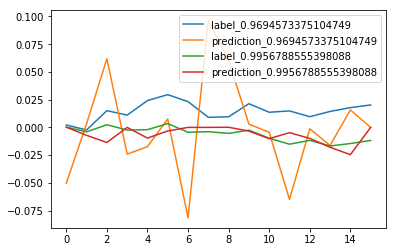

In [5]:
import pandas as pd
df = pd.DataFrame(acc_callback.worst_sample)
df.plot()